In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from IPython.display import Markdown, display

## Key inputs

In [2]:
filename = ('SampleData.csv')
role_lookup = ('') 

In [3]:
data = pd.read_csv(filename)

# All functions

In [4]:
def clean_dataset (data, CaseID= 'caseid_column', Activity= 'activity_column' , StartTimeStamp= 'start_column' , EndTimeStamp= 'end_column'):
    # this function is to change the type of each log column to the right python format
    
    # Create a dictionary to map old column names to new column names
    rename_dict = {CaseID: 'CaseID', Activity: 'Activity', StartTimeStamp: 'StartTimeStamp', EndTimeStamp: 'EndTimeStamp' }
    
    # Use the rename method to rename the columns in the DataFrame
    data = data.rename(columns=rename_dict)
    
    # fix columns data types in python
    # Convert CaseId column to string
    data['CaseID'] = data['CaseID'].astype('str')
    
    # convert datetime column and get the dd-mm right
    data['StartTimeStamp'] = pd.to_datetime(data['StartTimeStamp'], dayfirst=True)
    data['EndTimeStamp'] = pd.to_datetime(data['EndTimeStamp'], dayfirst=True)
    
    
    return data



def visualise_dataset(data):
    ## this function is to provide basic information & visualize the dataset
    
    # Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case:
    case_starts_ends = data.pivot_table(index='CaseID', aggfunc={'StartTimeStamp': ['min'],'EndTimeStamp': ['max'] })
    case_starts_ends = case_starts_ends.reset_index() 
    case_starts_ends.columns = ['CaseID', 'CaseEnd', 'CaseStart'] 

    # Merge with the main event log data so that for each row we have the start and end times.
    data = data.merge(case_starts_ends, on='CaseID') 
    
    # Calculate the relative time by subtracting the process start time from the event timestamp
    data['RelativeTime'] = data['StartTimeStamp'] - data['CaseStart']

    # Calculate case length
    data['CaseLength'] = data['CaseEnd'] - data['CaseStart']
    
    # Convert relative times to more friendly measures (days)
    data['RelativeTime_days'] = data['RelativeTime'].dt.total_seconds() / 86400
    
    
     ## Visualise which activities are common to cases
    heat_map = pd.crosstab(data['CaseID'], data['Activity'])
    heat_map = heat_map.applymap(lambda x: 1 if x > 0 else 0)
    
    nunique = heat_map.apply(pd.Series.nunique)
    shared_actions = nunique[nunique==1].index
    print('**The following actions are common to all cases**: {}'.format(', '.join(shared_actions)))
    
    plt.figure(figsize=(15, 6))
    sns.heatmap(heat_map, cmap='YlGnBu')
    plt.title('Heatmap showing common activities across all cases')
    plt.show()

    ## Visualise a dotted chart 
    

    plt.figure(figsize=(15, 6))
    ax = sns.scatterplot(x=data['StartTimeStamp'], y=data['CaseID'], hue=data['Activity'])
    plt.title('Dotted chart showing the event flow over absolute time')
    plt.show()
    
    ## Dotted chart Order by the case length
    ordered = data.sort_values(by=['CaseLength', 'CaseID', 'RelativeTime_days'])

    plt.figure(figsize=(15, 8))
    ax = sns.scatterplot(x=ordered['RelativeTime_days'], y=ordered['CaseID'], hue=ordered['Activity']) 
    plt.title('Dotted chart ordered by case length')
    plt.show()


In [5]:
def dataset_info (data):
    # Provide basic information on dataset
    
    print('{} has {} rows and {} columns.'.format(filename, data.shape[0], data.shape[1]))
    print(" ")
        
    print('Number of unique Cases in dataset : {} '.format( len(data['CaseID'].drop_duplicates())))
    print('Number of unique Activities in dataset : {} '.format( len(data['Activity'].drop_duplicates())))
    print(" ")
    
    print('Minimum number of Activities per case : {}'.format(min(data['CaseID'].value_counts()))) 
    print('Maximum number of Activities per case : {}'.format(max(data['CaseID'].value_counts()))) 
    
    print(" ")
    print('Dataset earliest date : {}'.format(data['StartTimeStamp'].min())) 
    print('Dataset latest date : {}'.format(data['EndTimeStamp'].max())) 
    

In [6]:
def StartAndEnd_activities(data):
    # This function is to present what are the most common activities at the begining and end of each case
    unique_cases = data['CaseID'].drop_duplicates().tolist()
    rows = []

    for case in unique_cases:
        case_activities = data[data['CaseID']==case]

        # Sort activities base on start tiemstamp 
        case_activities = case_activities.sort_values(by='StartTimeStamp', ascending= True) 

        # Get the first activity in case
        first_activity = case_activities['Activity'].iloc[0]

        # Sort activities based on End TimeStamp 
        case_activities = case_activities.sort_values(by='EndTimeStamp', ascending= True) 

        # Get the last activity in case
        last_activity = case_activities['Activity'].iloc[-1]
        rows.append ({
            'CaseID' : case,
            'first_activity' : first_activity,
            'last_activity' : last_activity
        
        })
    
    # create a dataframe and list common first & last activities
    summary_list = pd.DataFrame(rows)
    first_activities = summary_list['first_activity'].value_counts()
    last_activities = summary_list['last_activity'].value_counts()
    
    
    # Graph the ourcomes
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot the data_series as a column chart
    first_activities.plot(kind='bar')

    # Customize the chart (e.g., labels, title, etc.)
    plt.title("Showing most commont acticities at the case start")
    plt.xlabel("First Activities")
    plt.ylabel("count")

    # Add data labels to the columns
    for i, v in enumerate(first_activities):
        ax.text(i, v, str(v), ha='center', va='bottom')

    # Show the chart
    plt.show()

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot the data_series as a column chart
    last_activities.plot(kind='bar')

    # Customize the chart (e.g., labels, title, etc.)
    plt.title("Showing most commont acticities at the case End")
    plt.xlabel("Last Activities")
    plt.ylabel("count")

    # Add data labels to the columns
    for i, v in enumerate(last_activities):
        ax.text(i, v, str(v), ha='center', va='bottom')

    # Show the chart
    plt.show()

In [7]:
def variants(data):
    # This function is to present how many variants in dataset
    unique_cases = data['CaseID'].drop_duplicates().tolist()
    rows = []

    for case in unique_cases:
        case_activities = data[data['CaseID']==case]

        # Sort activities base on start tiemstamp 
        case_activities = case_activities.sort_values(by='StartTimeStamp', ascending= True) 
        
        # Capture the series of activity in a long string
        case_journey = case_activities['Activity'].str.cat(sep='>')
        

        rows.append ({
            'CaseID' : case,
            'case_journey' : case_journey,
        })
    
    # create a dataframe and list common first & last activities
    summary_list = pd.DataFrame(rows)
    case_journey = summary_list['case_journey'].value_counts()
    
    print('Number of variants in dataset : {} '.format( len(case_journey)))
    print('Variants percentage to Cases in dataset : {}% '.format( int((len(case_journey)/len(data['CaseID'].drop_duplicates())*100))))
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot the data_series as a column chart
    case_journey.plot(kind='bar')

    # Customize the chart (e.g., labels, title, etc.)
    plt.title("Showing most commont Variants in dataset")
    plt.xlabel("Variant")
    plt.ylabel("count")

    # Add data labels to the columns
    for i, v in enumerate(case_journey):
        ax.text(i, v, str(v), ha='center', va='bottom')

    # Show the chart
    plt.show()

## Clean & Organise Dataset

In [8]:
# link key log columns to organise dataset
data = clean_dataset(data, 
                     CaseID= "CaseId", 
                     Activity = 'ActivityName', 
                     StartTimeStamp= 'StartTimestamp',
                     EndTimeStamp= 'EndTimestamp' 
                    )

## Dataset discovery

In [9]:
dataset_info(data)

SampleData.csv has 1004 rows and 9 columns.
 
Number of unique Cases in dataset : 133 
Number of unique Activities in dataset : 13 
 
Minimum number of Activities per case : 5
Maximum number of Activities per case : 20
 
Dataset earliest date : 2022-07-14 09:49:50.518465
Dataset latest date : 2022-08-26 14:12:27.438235


**The following actions are common to all cases**: Invoice Entry, Re-issuing the invoice


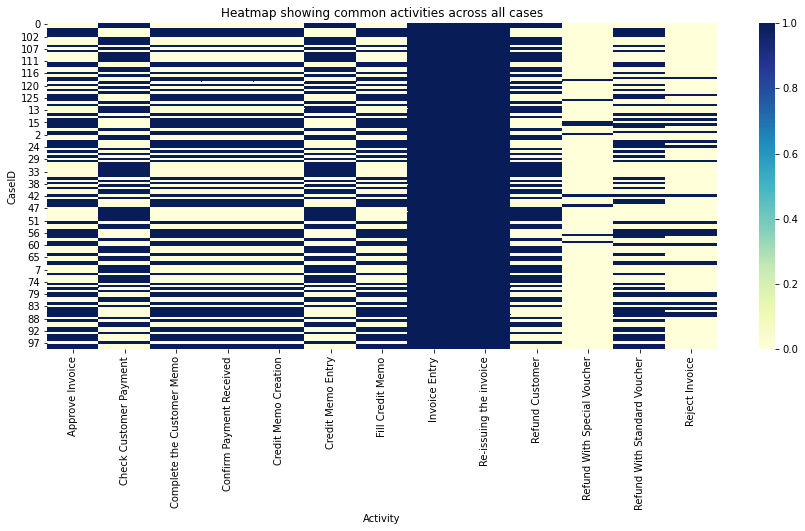

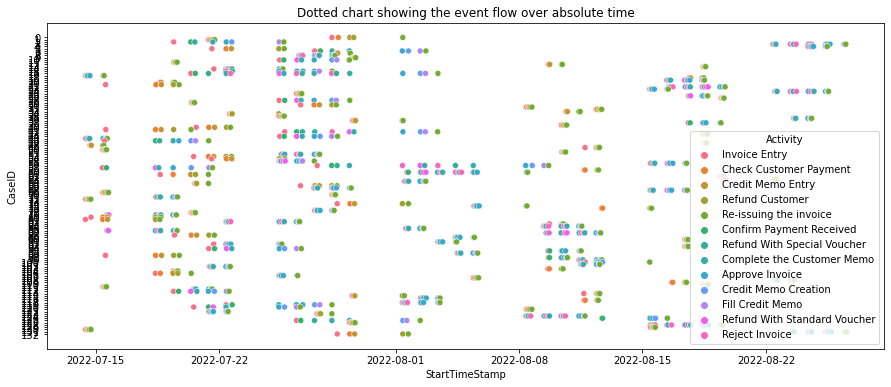

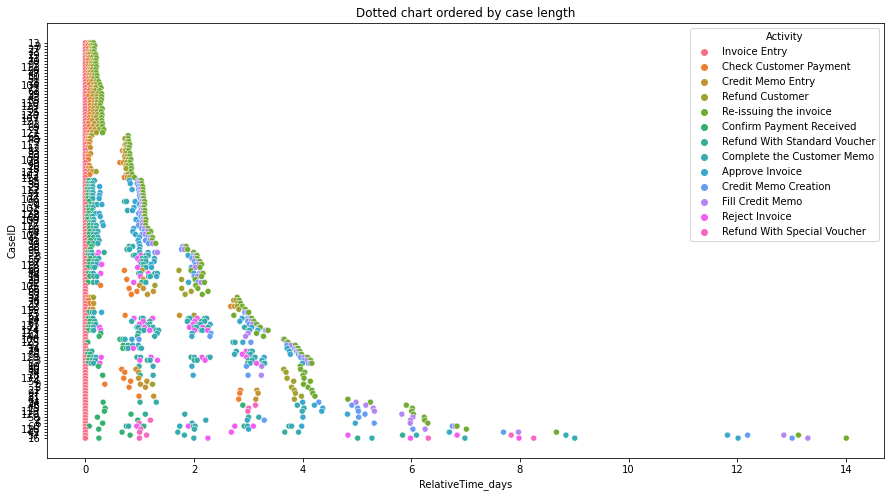

In [10]:
visualise_dataset(data)

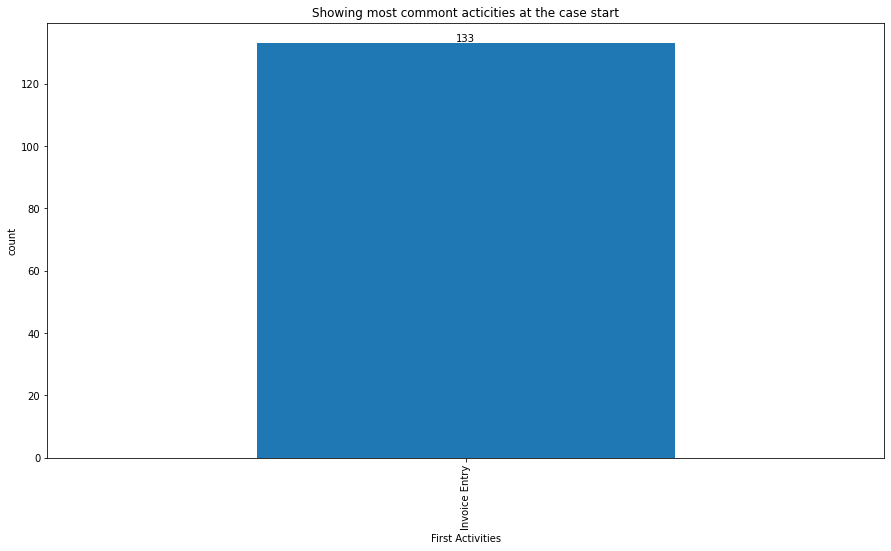

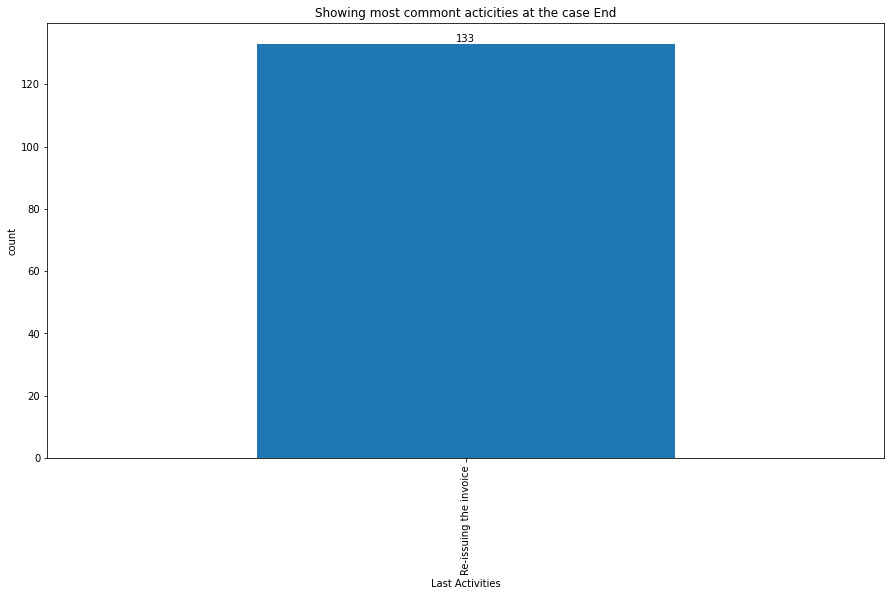

In [11]:
StartAndEnd_activities(data)

Number of variants in dataset : 10 
Variants percentage to Cases in dataset : 7% 


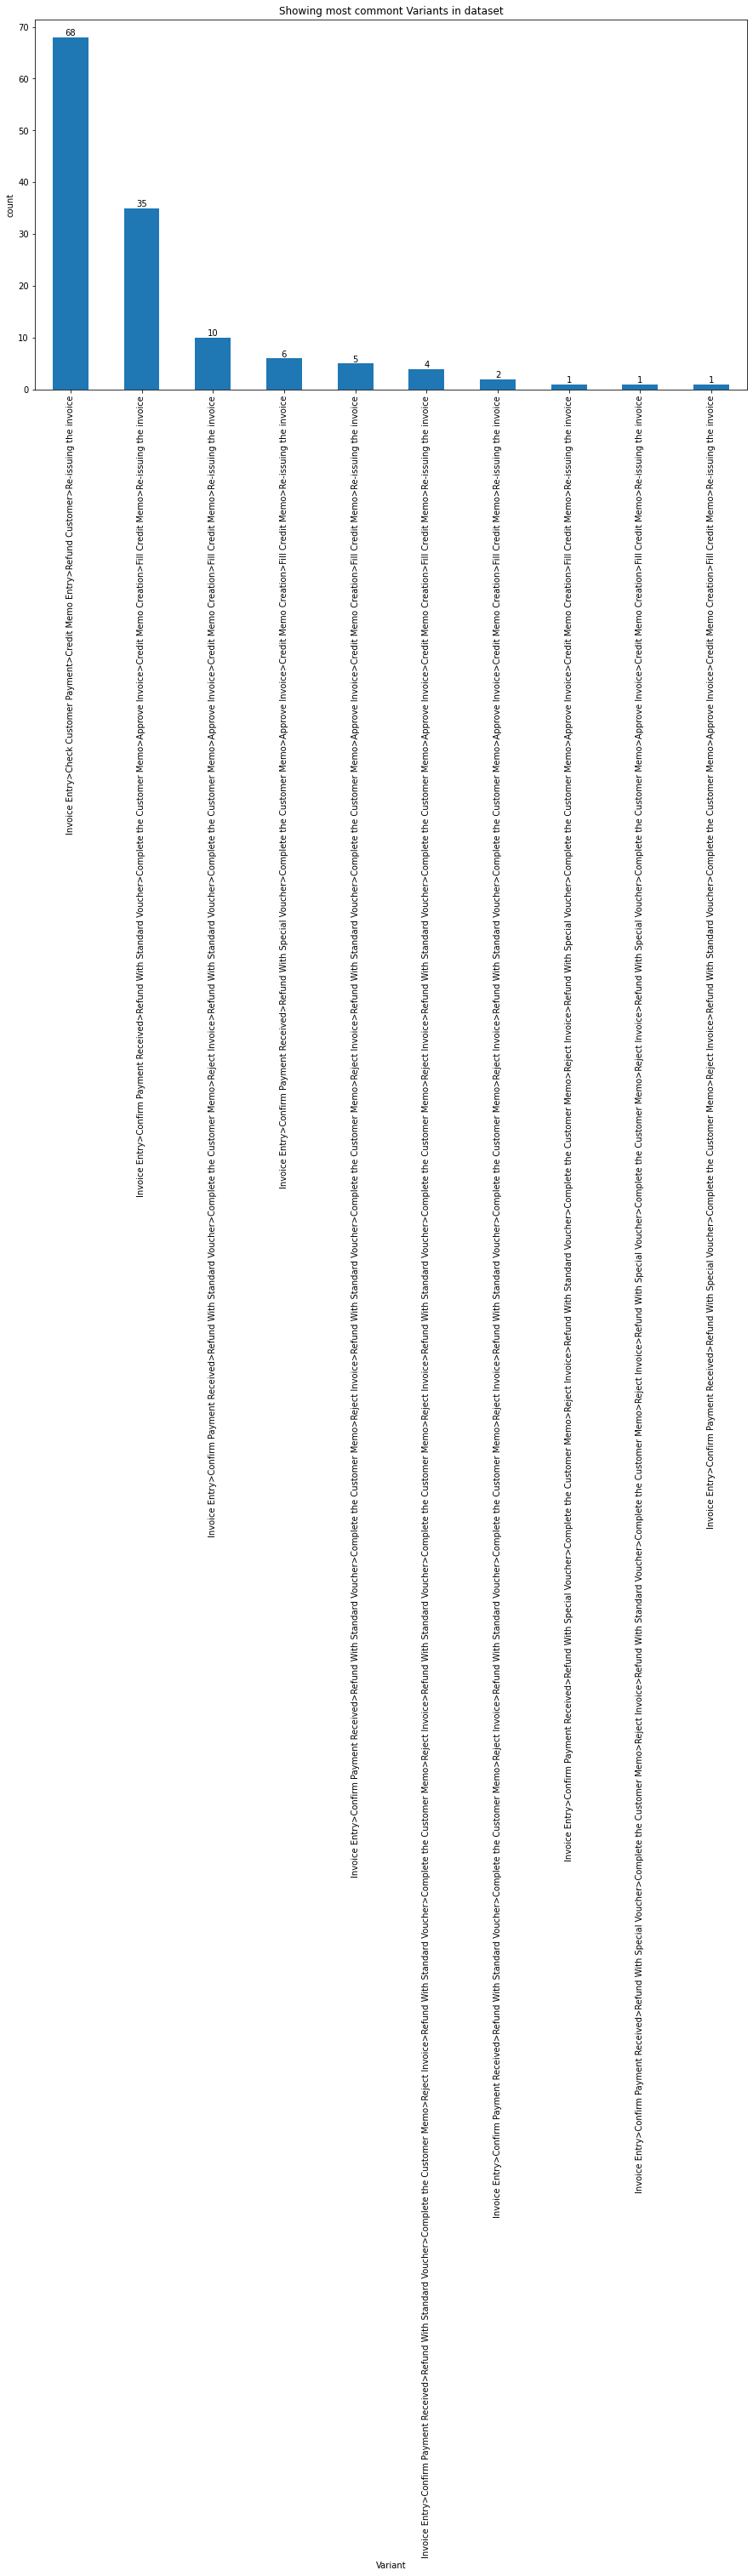

In [12]:
variants(data)

In [15]:
data[data['CaseID']=='10']

,Location,Role,VendorID,InvoiceValue,Resource,StartTimeStamp,EndTimeStamp,CaseID,Activity
80,"San Diego, USA",Invoice Processor,Vendor5,1020.03,Abbie,2022-07-25 10:07:36.138787,2022-07-25 15:53:52.338787,10,Invoice Entry
81,"San Diego, USA",Invoice Processor,Vendor5,1020.03,Abbie,2022-07-25 15:53:52.338787,2022-07-25 22:52:09.738787,10,Confirm Payment Received
82,"San Diego, USA",Invoice Processor,Vendor5,1020.03,Abbie,2022-07-26 09:52:09.738787,2022-07-26 16:03:21.738787,10,Refund With Standard Voucher
83,"San Diego, USA",Invoice Approver,Vendor5,1020.03,Jessie,2022-07-26 16:03:21.738787,2022-07-26 23:12:27.138787,10,Complete the Customer Memo
84,"San Diego, USA",Invoice Approver,Vendor5,1020.03,Jessie,2022-07-27 09:12:27.138787,2022-07-27 19:18:15.738787,10,Approve Invoice
85,"San Diego, USA",Invoice Processor,Vendor5,1020.03,Abbie,2022-07-28 09:18:15.738787,2022-07-28 16:03:38.538787,10,Credit Memo Creation
86,"San Diego, USA",Invoice Processor,Vendor5,1020.03,Abbie,2022-07-28 16:03:38.538787,2022-07-28 22:04:33.138787,10,Fill Credit Memo
87,"San Diego, USA",Invoice Processor,Vendor5,1020.03,Abbie,2022-07-29 09:04:33.138787,2022-07-29 15:32:25.938787,10,Re-issuing the invoice


In [18]:
data[data['Role']=='Invoice Processor']['Activity'].value_counts()

Invoice Entry                   133
Re-issuing the invoice          133
Refund With Standard Voucher    101
Credit Memo Entry                68
Check Customer Payment           68
Refund Customer                  68
Confirm Payment Received         65
Fill Credit Memo                 65
Credit Memo Creation             65
Refund With Special Voucher      12
Name: Activity, dtype: int64

In [19]:
data[data['Role']=='Invoice Approver']['Activity'].value_counts()

Complete the Customer Memo    113
Approve Invoice                65
Reject Invoice                 48
Name: Activity, dtype: int64

## Resource allocation 

In [21]:
pd.crosstab(data['Activity'], data['Role'])

Role,Invoice Approver,Invoice Processor
Activity,,
Approve Invoice,65,0
Check Customer Payment,0,68
Complete the Customer Memo,113,0
Confirm Payment Received,0,65
Credit Memo Creation,0,65
Credit Memo Entry,0,68
Fill Credit Memo,0,65
Invoice Entry,0,133
Re-issuing the invoice,0,133


In [23]:
pd.crosstab(data['Activity'], data['Role'], normalize='columns')

Role,Invoice Approver,Invoice Processor
Activity,,
Approve Invoice,0.287611,0.000000
Check Customer Payment,0.000000,0.087404
Complete the Customer Memo,0.500000,0.000000
Confirm Payment Received,0.000000,0.083548
Credit Memo Creation,0.000000,0.083548
Credit Memo Entry,0.000000,0.087404
Fill Credit Memo,0.000000,0.083548
Invoice Entry,0.000000,0.170951
Re-issuing the invoice,0.000000,0.170951


In [ ]:
# Create a list of unique CaseIds
unique_CaseID = data['CaseID'].drop_duplicates().tolist()

## 1. Create a new raw for a starting activity
Not needed if the data don't have "Start Time Stamp"

In [ ]:
# 1. Add an extra raw for each application as a start activity
for app in app_numbers:
    app_events = data[data['CaseID']==app]
    
    #Sort events based on StartTimestamp
    app_events = app_events.sort_values (by='StartTimeStamp', ascending = True)
    
    # Duplicate first raw to dataset
    row_to_duplicate = app_events.iloc[0]
    data = data.append(row_to_duplicate, ignore_index=True)
    
    # Get and sort app events again
    app_events = data[data['CaseID']==app]
    
    #Sort events based on StartTimestamp
    app_events = app_events.sort_values (by='StartTimeStamp', ascending = True)    
    
    # Replace values in the newly created row
    new_index = app_events.index[0]
    new_activity_name = 'start'
    new_role_name = 'start'
    new_end_timestamp = app_events ['StartTimeStamp'].iloc[0]
    
    data.at[data.index[new_index],'Activity'] = new_activity_name
    data.at[data.index[new_index],'EndTimeStamp'] = new_end_timestamp
    data.at[data.index[new_index],'Role'] = new_role_name

In [ ]:
# Test previous code
data[data['CaseId']=='1'].sort_values(by='StartTimestamp', ascending = True)

In [ ]:
# Add "total step time (minutes)" calculated column
data ['TotalStepTime'] = data['EndTimestamp'] - data['StartTimestamp']

# Convert timedelta to minutes
data['TotalStepTime(minutes)'] = data ['TotalStepTime'].dt.total_seconds() / 60

data = data.drop('TotalStepTime', axis=1)

## 2. Create a lookup table of AHT estimates

these should be a way to simplify this or create the table in a separate spreadsheet

In [ ]:
data['Role'].drop_duplicates()

In [ ]:
# Please input Average Handeling time in minutes (for every touch) - and the max processing time as multiple of the AHT

InvoiceProcessor_aht = 60
InvoiceApprover_aht = 30

max_multiply = 5

In [ ]:
# Calculate the average TotalStepTime in dataset
InvoiceProcessor_atst = data[data['Role']=='Invoice Processor']['TotalStepTime(minutes)'].mean()
InvoiceApprover_atst = data[data['Role']=='Invoice Approver']['TotalStepTime(minutes)'].mean()

# Calculte the maximum processing time in minutes as a multiplyer of AHT
InvoiceProcessor_max = max_multiply * InvoiceProcessor_aht
InvoiceApprover_max = max_multiply * InvoiceApprover_aht

#Calculate te conversion rate and build a lookup table
lookup = [['Invoice Processor', InvoiceProcessor_atst/InvoiceProcessor_aht , InvoiceProcessor_max ],
         ['Invoice Approver', InvoiceApprover_atst/InvoiceApprover_aht , InvoiceApprover_max ]]

lookup = pd.DataFrame(lookup, columns=['Role' , 'ConversionConstant' , 'MaxValue'])

In [ ]:
# Add lookup tablel to data
data = pd.merge(data, lookup, on='Role', how='left')

In [ ]:
# Calculate the estimated processing time & round the outcome
data['EstimatedProcessingTime(minutes)'] = data['TotalStepTime(minutes)'] / data['ConversionConstant']
data['EstimatedProcessingTime(minutes)'] = data['EstimatedProcessingTime(minutes)'].round(2)

# Cap processing time at the threshould above
data['EstimatedProcessingTime(minutes)'] = data.apply(lambda row: min(row['MaxValue'], 
                                                                      row['EstimatedProcessingTime(minutes)']),axis=1)
# Drop extra columns
data = data.drop('ConversionConstant', axis=1)
data = data.drop('MaxValue', axis=1)

# Sort the dataset
data = data.sort_values(by='StartTimestamp', ascending=True)
data = data.sort_values(by='CaseId', ascending=True)

# Fill empty cells with 0
data['EstimatedProcessingTime(minutes)'] = data['EstimatedProcessingTime(minutes)'].fillna(0)

## 3. Create new Start Time Stamps

In [ ]:
# Create a new process start timestamp considering the estimated processing times
data['ProcessingTimedelta'] = pd.to_timedelta(data['EstimatedProcessingTime(minutes)'], unit='m')
data['new_StartTimestamp'] = data['EndTimestamp'] - data['ProcessingTimedelta']

data=data.drop('ProcessingTimedelta', axis=1)

In [ ]:
# Export output data
data.to_csv ('OutputDataset.csv', index=False)